## Introduction

The league's settings must indicate it is "public" it to be read into Python. For reference, I play in a 10 team, standard scoring, auction draft, FAAB league. Playoffs include Week 17. 4 out of the 10 total teams make the playoffs. Playoff matchups are each 2 weeks long. So, the regular season ends after Week 13. The tie-breaker between teams is points.

Note, once the 2019 season is over, the URL will change from "current" to "history" and will have to be changed.

Getting Started with the Necessary Packages:

In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings #dealing with some of the Pandas subsetting
warnings.filterwarnings('ignore')

In [2]:
#The necessary unique identifiers to import the current (2019) year's JSON
league_year = 2019
league_id = 298982

url = "https://fantasy.espn.com/apis/v3/games/ffl/seasons/" + str(league_year) + "/segments/0/leagues/" + str(league_id)

#With the URL saved, we load it into the environment
r = requests.get(url, params = {"view": "mMatchup"})
d = r.json()

I'll also add the dictionary for team owners. I'm sure somewhere within <code>d</code> the team owners and respective team IDs are available, but since I already know the order I'm going to manually create the dictionary:

In [3]:
mapping = {1: "Mount",
           2: "Alec",
           3: "Sirpi",
           4: "Oatman",
           5: "Babcock",
           9: "Jordan",
           11: "Casey",
           12: "Badillo",
           13: "Naki",
           14: "Kooper"}

### Win Loss Records

Viewing the <code>mMatchup</code> is only one of the subsets of data the JSON pulls. Quite a few more exist, but for this project only <code>mMatchup</code> will be used.

<code>d</code> is a huge object. Since this exploration deals with just the schedule, we'll take a look at that. I know the shape of the dictionary with how much time I've spent on this, so I'll quickly cut to pulling the matchup data:  

In [4]:
#How many weeks of material to pull?
maximum = max(pd.DataFrame(d["schedule"]).index.tolist()) #how may games exist in the schedule?
length_df = pd.DataFrame([[d["schedule"][i]["winner"]] for i in range(maximum)]) #who won each matchup?
length_df.tail()

,0
69,HOME
70,UNDECIDED
71,UNDECIDED
72,UNDECIDED
73,UNDECIDED


As we can see, after 70 games (index at 0), there are some "undecided" results. This is due to the structure of my fantasy league, in which we have set some relatively arbitrary playoff rules. As they don't affect this analysis, I won't go over them. Essentially, those regular season games are "not played". Regardless, we should nix those undecided matchups since they have no data.

In [8]:
length_df = length_df[length_df[0] != "UNDECIDED"]
length = range(len(length_df))
length_df.tail()

,0
65,HOME
66,AWAY
67,HOME
68,HOME
69,HOME


The Undecideds are gone, and we have the number of rows in the Data Frame stored in <code>length</code>.

Now, we want to get the source data: the scores, the weeks, and the teams.

In [6]:
source = pd.DataFrame([[d["schedule"][i]["matchupPeriodId"],
                        d["schedule"][i]["home"]["teamId"],
                        d["schedule"][i]["home"]["totalPoints"],
                        d["schedule"][i]["away"]["teamId"],
                        d["schedule"][i]["away"]["totalPoints"]] for i in length],
                        columns = ["Week", "Team1", "Score1", "Team2", "Score2"])

#Since End of Regular Season is Week 13
source = source[source.Week <= 13]

#Add a column for Margin of Victory (MOV) and Margin of Loss
margins = source.assign(Margin1 = source.Score1 - source.Score2,
                       Margin2 = source.Score2 - source.Score1)
margins.head(10)

,Week,Team1,Score1,Team2,Score2,Margin1,Margin2
0,1,11,77.0,13,91.0,-14.0,14.0
1,1,1,130.0,12,76.0,54.0,-54.0
2,1,5,92.0,2,91.0,1.0,-1.0
3,1,9,124.0,4,82.0,42.0,-42.0
4,1,14,108.0,3,145.0,-37.0,37.0
5,2,3,76.0,13,106.0,-30.0,30.0
6,2,5,73.0,11,86.0,-13.0,13.0
7,2,1,119.0,4,71.0,48.0,-48.0
8,2,2,105.0,12,77.0,28.0,-28.0
9,2,14,91.0,9,84.0,7.0,-7.0


Great, we can see the matchups per week. Now, we consolidate all the teams into a single column; transforming the data from wide to long.

In [7]:
margins_long = (margins[["Week", "Team1", "Margin1", "Score1"]]
                .rename(columns = {"Team1": "Team",
                                   "Margin1": "Margin",
                                   "Score1": "Score"})
                .append(margins[["Week", "Team2", "Margin2", "Score2"]]
                .rename(columns = {"Team2": "Team",
                                   "Margin2": "Margin",
                                   "Score2": "Score"})))

#add team name to the margins_long data frame
margins_long = (margins_long.assign(teamname = margins_long.Team)
                            .replace({"teamname": mapping}))

#creating record from values
team_ids = margins_long.Team.unique()

margins_long.head()

,Week,Team,Margin,Score,teamname
0,1,11,-14.0,77.0,Casey
1,1,1,54.0,130.0,Mount
2,1,5,1.0,92.0,Babcock
3,1,9,42.0,124.0,Jordan
4,1,14,-37.0,108.0,Kooper


So now our source Data Frame has the Week, Team ID, MOV, and the owner. A separate object for the Team Numbers <code>team_ids</code> is created on the side for later use. Using this <code>margins_long</code> Data Frame, we will create the win-loss record for each team. First we'll define a function that goes through and and takes each team by week, and figure out if that week is a win, loss, or a tie (since we don't use decimal scoring):

In [9]:
def team_win_loss(dataset, i):
    """
    Adding the win-loss record
    dataset: which dataset to use?
    i: iterator
    """
    team = dataset[dataset["Team"] == team_ids[i]]
    team_wins = sum(n > 0 for n in team["Margin"])
    team_ties = sum(n == 0 for n in team["Margin"])
    team_loss = sum(n < 0 for n in team["Margin"])
    
    points = np.sum(team.Score)
    wl_info = pd.DataFrame([[team_ids[i], team_wins, team_loss,
                             team_ties, points]],
                           columns = ["Team", "Wins", "Losses", "Ties",
                                      "Points"])
    return wl_info

<code>wl_info</code> contains each team's individual record. The data set will be iterated through to create a data set of win-loss records.

In [10]:
#initialize an empty dataframe to append to
win_loss = []

#loop through all the teams and have the rows append
for j in range(len(team_ids)):
    row = team_win_loss(margins_long, j)
    win_loss.append(row)
win_loss = (pd.concat(win_loss)
              .sort_values(by = ["Wins", "Ties", "Points"], ascending = False)
              .assign(Standing = np.arange(1, 11))
              .reset_index(drop = True))
win_loss = (win_loss.assign(teamname = win_loss.Team,
                            Record = win_loss.Wins.map(str)
                                        + "-"
                                        + win_loss.Losses.map(str)
                                        + "-"
                                        + win_loss.Ties.map(str))
                    .replace({"teamname": mapping}))

win_loss

,Team,Wins,Losses,Ties,Points,Standing,teamname,Record
0,1,9,3,1,1268.0,1,Mount,9-3-1
1,3,8,4,1,1411.0,2,Sirpi,8-4-1
2,9,8,4,1,1226.0,3,Jordan,8-4-1
3,2,8,5,0,1198.0,4,Alec,8-5-0
4,13,7,6,0,1209.0,5,Naki,7-6-0
5,14,6,7,0,1121.0,6,Kooper,6-7-0
6,11,6,7,0,1055.0,7,Casey,6-7-0
7,5,5,8,0,1124.0,8,Babcock,5-8-0
8,12,3,9,1,1104.0,9,Badillo,3-9-1
9,4,3,10,0,992.0,10,Oatman,3-10-0


### Win Loss Margins

A boxplot would do well to visualize the margins for each team:

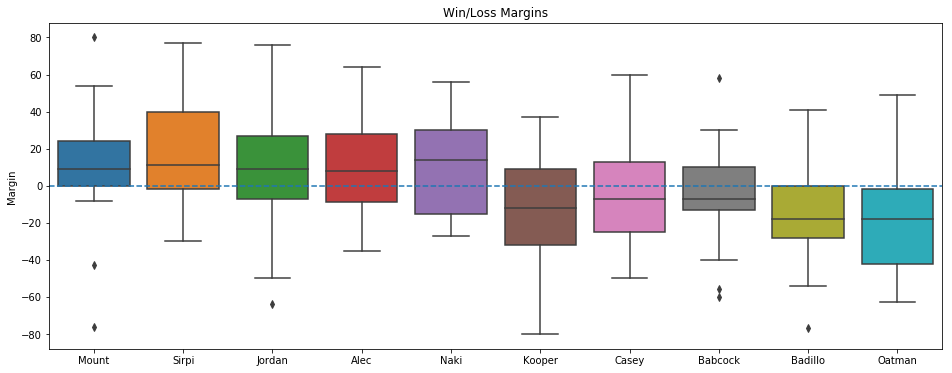

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (16, 6))
order = win_loss.teamname
sns.boxplot(x = "teamname", y = "Margin", data = margins_long, order = order)
ax.axhline(0, ls = "--")
ax.set_xlabel("")
ax.set_title("Win/Loss Margins")
plt.show()

### Luck
Is there a way to retrospectively visualize and quantify luck? Here's an attempt. Luck will be represented as such:

1. If Team 1 beats Team 2 and both scored above the weekly average, Team 1 got a good win.
2. If Team 1 beats Team 2 and both scored below the weekly average, Team 1 got a lucky win.
3. If Team 1 beats Team 2 and Team 1 scored above the weekly average and Team 2 scored below, Team 1 got an expected win.
4. If Team 1 lost to Team 2 and both scored above the weekly average, Team 1 got an unlucky loss.
5. If Team 1 lost to Team 2 and both scored below the weekly average, Team 1 got a bad loss.
6. If Team 1 lost to Team 2 and Team 1 scored below the weekly average and Tem 2 scored above, Team 1 got an expected loss.

A data set will be created accompanied by a graphic to visualize this.



First, we'll need to find the weekly average score:

In [12]:
averages = (margins.filter(["Week", "Score1", "Score2"])
                   .melt(id_vars = ["Week"],
                         value_name = "Score")
                   .groupby("Week")
                   .mean()
                   .reset_index())
averages

,Week,Score
0,1,101.6
1,2,88.8
2,3,96.1
3,4,80.2
4,5,97.7
5,6,86.4
6,7,85.3
7,8,98.9
8,9,85.7
9,10,95.3


Now that we have the weekly averages, we want to create an indicator variable in our old <code>margins</code> data set. The preferred output is to have each team, who they played each week, their Margin of Victory/Loss, a binary Win/Loss indicator, and how far they were from the weekly average that was calculated in the Data Frame above. These additional variables will make the visualization easier to define luck:

In [13]:
#initialize empty list
margin_average = []

for i in range(len(team_ids)):
    #select the team and corresponding owner name
    team = team_ids[i]
    team_owner = mapping[team]
    
    #create a dataframe for the score margin against team average per week
    df2 = (margins.query("Team1 == @team | Team2 == @team")
                  .reset_index(drop = True))
    #move df2 to have all team of interest into one column
    team_loc = list(df2["Team2"] == team)
    df2.loc[team_loc,
            ["Team1", "Score1",
             "Team2", "Score2"]] = df2.loc[team_loc, ["Team2", "Score2",
                                                      "Team1", "Score1"]].values
    #Add new score and win columns
    df2 = (df2.assign(change1 = df2["Score1"] - averages["Score"],
                  change2 = df2["Score2"] - averages["Score"],
                  Win = df2["Score1"] > df2["Score2"]))
    
    #Append it to the end
    margin_average.append(df2)
    
#concatenate into a usable Data Frame
margin_average = pd.concat(margin_average)

margin_average.head()

,Week,Team1,Score1,Team2,Score2,Margin1,Margin2,change1,change2,Win
0,1,11.0,77.0,13.0,91.0,-14.0,14.0,-24.6,-10.6,False
1,2,11.0,86.0,5.0,73.0,-13.0,13.0,-2.8,-15.8,True
2,3,11.0,68.0,2.0,118.0,-50.0,50.0,-28.1,21.9,False
3,4,11.0,52.0,9.0,91.0,39.0,-39.0,-28.2,10.8,False
4,5,11.0,86.0,4.0,68.0,18.0,-18.0,-11.7,-29.7,True


With the data set prepared, we now make the graphic. First, a function will be defined. Then, limits will be set to create a visually aesthetic graphic:

In [14]:
def luck_graphic(index):
    #Index is team number
    team = team_ids[index]
    team_owner = mapping[team]
    team_rec = (win_loss[win_loss.Team == team].Record
                                               .to_string(index = False)
                                               .strip())
    
    #pull the necessary data
    graph_data = margin_average[margin_average.Team1 == team]
        
    ax = sns.scatterplot(x = "change1", y = "change2", data = graph_data,
                     style = "Win")
    plt.title("Team " + str(team_owner) + " Scores (Centered at Weekly League Average)\nRecord: " + team_rec)
    plt.ylim(-(plot_limit + 1), plot_limit + 1)
    plt.xlim(-(plot_limit + 1), plot_limit + 1)
    ax.spines["left"].set_position("zero")
    ax.spines["bottom"].set_position("zero")
    ax.spines['right'].set_color("none")
    ax.spines['top'].set_color("none")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.fill_between(x_fill, 0, y_fill, color = "blue", alpha = 0.2)
    ax.fill_between(y_fill, x_fill, plot_limit + 1, color = "red", alpha = 0.2)
    ax.fill_between(x_negf, 0, y_negf, color = "red", alpha = 0.2)
    ax.fill_between(y_negf, x_negf, -(plot_limit + 1), color = "blue",
                    alpha = 0.2)
    ax.plot([-(plot_limit + 1), plot_limit + 1],
            [-(plot_limit + 1), plot_limit + 1],
            color = "black",
            linestyle = "-.")
    ax.text(-(plot_limit * .16), (plot_limit * 0.8), "Points\nAgainst",
            color = "black", size = "medium",
            horizontalalignment = "center", style = "italic")
    ax.text((plot_limit * 0.9), -(plot_limit * .25), "Points\nFor",
            color = "black", size = "medium",
            horizontalalignment = "center", style = "italic")
    ax.text((plot_limit * .16), (plot_limit * 0.8), "Unlucky\nLoss",
            color = "red", size = "medium",
            horizontalalignment = "center", style = "italic")
    ax.text(-(plot_limit * .16), -(plot_limit * 0.9), "Lucky\nWin",
            color = "blue", size = "medium",
            horizontalalignment = "center", style = "italic")
    ax.text((plot_limit * 0.9), (plot_limit * .25), "Good\nWin",
            color = "blue", size = "medium",
            horizontalalignment = "center", style = "italic")
    ax.text(-(plot_limit * .9), -(plot_limit * 0.16), "Bad\nLoss",
            color = "red", size = "medium",
            horizontalalignment = "center", style = "italic")

In [15]:
#limits to plot against: max and min of margins
marg_max = max(margin_average.iloc[:, [7, 8]].max(axis = 1))
marg_min = min(margin_average.iloc[:, [7, 8]].min(axis = 1))
plot_limit = max(marg_max, np.abs(marg_min))

#now make it into a graphic
x_fill = np.arange(0.0, plot_limit + 1, 0.01)
y_fill = np.arange(0.0, plot_limit + 1, 0.01)
x_negf = np.arange((plot_limit +1) * -1, 0, 0.01)
y_negf = np.arange((plot_limit +1) * -1, 0, 0.01)

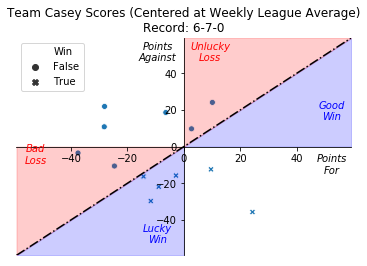

In [16]:
luck_graphic(0)

Obviously, there are 9 more graphics, one for each team, but outputting just 1 should give an idea of how to read this.

1. x-axis: Points For
2. y-axis: Points Against
3. Quadrant 2: Points Against > Weekly Average, Points For < Weekly Average. Expected Loss.
4. Quadrant 4: Points Against < Weekly Average, Points For > Weekly Average. Expected Win.
5. Quadrant 1, blue half: Points For > Points Against > Weekly Average. Good Win.
6. Quadrant 1, red half: Points Against > Points For > Weekly Average. Unlucky Loss.
7. Quadrant 3, blue half: Weekly Average > Points For > Points Against. Lucky Win.
8. Quadrant 3, red half: Weekly Average > Points Against > Points For. Bad loss.

### Heat Map and Weekly Simulation
A huge part of fantasy football is luck. Who starts in the lineup, how well they do compared to their expected score, etc. A tried and true argument of fantasy football is how much the league wants to rely on luck and how much of the results should be skill-based. So, an interesting metric to measure is a simulation if every team played every other team every week. The rapidly increased sample size would provide a better idea of how a team performed week by week. As there are 10 teams in my league, each team can go 0-9 to 9-0 every week: the lowest or the highest score of the week. This metric is entirely scores and points based, and doesn't touch individual matchups.

In [17]:
def weekly_aggregate(i):
    """
    subset all scores by a given week then add record, wins, scores
    """
    #all the scores for the week, sorted, and adding columns for the w/l/t
    scores = (margins_long[margins_long.Week == (i + 1)]
                .sort_values(by = ["Score"])
                .reset_index(drop = True)
                .assign(total_wins = np.arange(0, len(team_ids), 1),
                        total_loss = np.arange(len(team_ids) - 1, -1, -1),
                        ind = np.arange(0, len(team_ids), 1)))
    
    #which values have matching scores?
    ties_loc = np.argwhere(np.array(scores.duplicated(subset = "Score",
                                                      keep = False)) == True)
    
    #split the duplicated and non-duplicated values into separate DFs
    scores_nod = (scores[~scores.total_wins.isin(ties_loc.flatten())]
                    .assign(total_ties = 0))
    scores_dup = scores[scores.total_wins.isin(ties_loc.flatten())]
    
    #what are the unique scores in the list of duplicates?
    unique_scores = scores_dup.Score.unique()
    
    #only run through the loop if there are duplicates
    if len(unique_scores) > 0:
        #loop through all the scores to add the ties
        #initiate list
        dup_list = []
        for j in range(len(unique_scores)):
            
            #iterating through all the repeated scores
            unique = scores[scores.Score == unique_scores[j]]
            
            #add in loss/wins
            unique.total_wins = min(unique.total_wins)
            unique.total_loss = min(unique.total_loss)
            unique = unique.assign(total_ties = len(team_ids) - 1
                                   - (unique.total_loss + unique.total_wins))
            
            dup_list.append(unique)
            
        #compile them
        dup_list = pd.concat(dup_list)
        dup_list = pd.concat([dup_list, scores_nod]).sort_values(by = ["ind"])
        return dup_list
    
    else:
        scores["total_ties"] = 0
        return scores

In [18]:
#initialize an empty dataframe to append to
full_wl = []
    
#loop through all the teams and have the rows append
for j in range(13):
    row = weekly_aggregate(j)
    full_wl.append(row)
    
#remove the first row which was just empty
full_wl = pd.concat(full_wl)

full_wl.head()

,Week,Team,Margin,Score,teamname,total_wins,total_loss,ind,total_ties
0,1,12,-54.0,76.0,Badillo,0,9,0,0
1,1,11,-14.0,77.0,Casey,1,8,1,0
2,1,4,-42.0,82.0,Oatman,2,7,2,0
3,1,13,14.0,91.0,Naki,3,5,3,1
4,1,2,-1.0,91.0,Alec,3,5,4,1


The loop has a manually set upper range of 13, since the regular season is 13 weeks long. To emulate this analysis during the season, <code>range(13)</code> can be replaced with <code>range(max(margins.Week))</code>. The function takes our original <code>margins_long</code> Data Frame and, for each week, arranges the team by the score, and applies 0 to 9 wins accordingly. So, the 5th highest score of that week went "5-4" against the league that week. Once again, as this league is standard scoring, ties may be possible with the rest of the league. The <code>full_wl</code> Data Frame contains Weeks 1 - 13.

Since the Data Frame is long with all the weeks, it must be aggregated and summed to have one observation/row per team.

In [19]:
#combining for one row per team
sum_scores = (full_wl.groupby("Team")
                     .sum()
                     .drop("Week", axis = 1)
                     .sort_values(by = "total_loss"))
sum_scores = sum_scores.assign(record = sum_scores.total_wins.map(str)
                                        + "-"
                                        + sum_scores.total_loss.map(str)
                                        + "-"
                                        + sum_scores.total_ties.map(str))
sum_scores

,Margin,Score,total_wins,total_loss,ind,total_ties,record
Team,,,,,,,
3,270.0,1411.0,80,36,80,1,80-36-1
1,139.0,1268.0,72,43,73,2,72-43-2
9,80.0,1226.0,64,47,69,6,64-47-6
2,123.0,1198.0,60,52,62,5,60-52-5
13,100.0,1209.0,59,56,60,2,59-56-2
14,-132.0,1121.0,58,59,58,0,58-59-0
5,-84.0,1124.0,53,60,56,4,53-60-4
12,-224.0,1104.0,49,66,49,2,49-66-2
11,-55.0,1055.0,44,70,45,3,44-70-3


<code>sum_scores</code> has the Team as the index, total points, and the simulated, everyone against everyone record.

This is nice information to have, but essentially is useless if we can't compare it to the actual record for the teams over the season and visually seeing the displacement. To do this, we'll have to merge the <code>sum_scores</code> Data Frame with the <code>win_loss</code> Data Frame above:

In [20]:
analysis = (sum_scores.assign(Team3 = sum_scores.index.tolist(),
                              Team2 = sum_scores.index.tolist(),
                              order = np.arange(1, 11, 1))
                      .replace({"Team2": mapping})
                      .merge(win_loss, how = "left", left_on = "Team2",
                             right_on = "teamname"))
analysis = (analysis[["Team2", "Points", "record", "Record"]]
            .assign(Difference = analysis["Standing"] - analysis["order"])
            .rename(columns = {"Team2": "Owner",
                               "record": "Simulated Record",
                               "Record": "ESPN Record"}))
analysis

,Owner,Points,Simulated Record,ESPN Record,Difference
0,Sirpi,1411.0,80-36-1,8-4-1,1
1,Mount,1268.0,72-43-2,9-3-1,-1
2,Jordan,1226.0,64-47-6,8-4-1,0
3,Alec,1198.0,60-52-5,8-5-0,0
4,Naki,1209.0,59-56-2,7-6-0,0
5,Kooper,1121.0,58-59-0,6-7-0,0
6,Babcock,1124.0,53-60-4,5-8-0,1
7,Badillo,1104.0,49-66-2,3-9-1,1
8,Casey,1055.0,44-70-3,6-7-0,-2
9,Oatman,992.0,33-83-1,3-10-0,0


This Data Frame merges in <code>win_loss</code>, checks the difference in standings against the simulated record, and adds that as a column while dropping extra, unnecessary information. So, we now have the aggregated records and displacement and we can observe that after 13 weeks, the teams that deserved to make the playoffs did, and the teams competing for the Sacko also deserve to be there.

This same information will not be split by Week and have individual Weeks be added as columns. This allows us to see Weekly performance for each team.

We'll start by manually setting column names as Week names:

In [21]:
colnames = "Week " + pd.Series(full_wl.Week.unique()).map(str)
colnames

0      Week 1
1      Week 2
2      Week 3
3      Week 4
4      Week 5
5      Week 6
6      Week 7
7      Week 8
8      Week 9
9     Week 10
10    Week 11
11    Week 12
12    Week 13
dtype: object

With the column names in place, new data frames will be created. One will contain the wins for each team each week, one with losses, and one with ties. The <code>.pivot</code> module will help transpose the data as such:

In [22]:
wins_pivot = full_wl.pivot(index = "Team", columns = "Week",
                           values = "total_wins")
loss_pivot = full_wl.pivot(index = "Team", columns = "Week",
                           values = "total_loss")
ties_pivot = full_wl.pivot(index = "Team", columns = "Week",
                           values = "total_ties")
wins_pivot.columns = colnames
loss_pivot.columns = colnames
ties_pivot.columns = colnames
wins_pivot

,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12,Week 13
Team,,,,,,,,,,,,,
1,8,9,7,9,9,6,7,8,1,0,0,8,0
2,3,7,8,7,3,9,3,2,2,5,2,3,6
3,9,2,9,8,7,4,9,9,9,1,9,4,0
4,2,0,3,0,1,1,2,0,5,4,7,6,2
5,5,1,4,5,2,2,8,2,0,5,7,7,5
9,7,4,5,5,5,0,4,4,6,9,1,8,6
11,1,5,0,1,4,3,5,4,8,2,5,0,6
12,0,3,1,3,5,7,0,6,3,7,3,2,9
13,3,8,2,4,8,7,1,7,4,3,4,5,3


In [23]:
loss_pivot

,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12,Week 13
Team,,,,,,,,,,,,,
1,1,0,2,0,0,3,2,1,8,9,9,0,8
2,5,2,1,2,6,0,6,6,7,3,7,6,1
3,0,7,0,1,2,5,0,0,0,8,0,5,8
4,7,9,6,9,8,8,7,9,4,5,1,3,7
5,4,8,5,3,7,7,1,6,9,3,1,2,4
9,2,5,4,3,3,9,5,4,3,0,8,0,1
11,8,4,9,8,5,6,4,4,1,7,4,9,1
12,9,6,8,6,3,1,9,3,6,2,6,7,0
13,5,1,7,5,1,1,8,2,5,6,5,4,6


In [24]:
ties_pivot

,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12,Week 13
Team,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,0,1,0,1,0,0,2
3,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,0,1,0,0,0,1,0,1,1,0,0
9,0,0,0,1,1,0,0,1,0,0,0,1,2
11,0,0,0,0,0,0,0,1,0,0,0,0,2
12,0,0,0,0,1,1,0,0,0,0,0,0,0
13,1,0,0,0,0,1,0,0,0,0,0,0,0


This data isn't helpful unless it's put together week-by-week:

In [25]:
pivoted_record = []
for i in range(0, wins_pivot.shape[1]):
    old_name = "Week " + str(i + 1)
    var_name = "Record " + str(i + 1)
    pivoted_record.append(pd.DataFrame(wins_pivot.iloc[:, i].map(str)
                                        + "-"
                                        + loss_pivot.iloc[:, i].map(str)
                                        + "-"
                                        + ties_pivot.iloc[:, i].map(str))
                            .rename(columns = {old_name: var_name}))
pivoted_record = pd.concat(pivoted_record, axis = 1)
pivoted_record

,Record 1,Record 2,Record 3,Record 4,Record 5,Record 6,Record 7,Record 8,Record 9,Record 10,Record 11,Record 12,Record 13
Team,,,,,,,,,,,,,
1,8-1-0,9-0-0,7-2-0,9-0-0,9-0-0,6-3-0,7-2-0,8-1-0,1-8-0,0-9-0,0-9-0,8-0-1,0-8-1
2,3-5-1,7-2-0,8-1-0,7-2-0,3-6-0,9-0-0,3-6-0,2-6-1,2-7-0,5-3-1,2-7-0,3-6-0,6-1-2
3,9-0-0,2-7-0,9-0-0,8-1-0,7-2-0,4-5-0,9-0-0,9-0-0,9-0-0,1-8-0,9-0-0,4-5-0,0-8-1
4,2-7-0,0-9-0,3-6-0,0-9-0,1-8-0,1-8-0,2-7-0,0-9-0,5-4-0,4-5-0,7-1-1,6-3-0,2-7-0
5,5-4-0,1-8-0,4-5-0,5-3-1,2-7-0,2-7-0,8-1-0,2-6-1,0-9-0,5-3-1,7-1-1,7-2-0,5-4-0
9,7-2-0,4-5-0,5-4-0,5-3-1,5-3-1,0-9-0,4-5-0,4-4-1,6-3-0,9-0-0,1-8-0,8-0-1,6-1-2
11,1-8-0,5-4-0,0-9-0,1-8-0,4-5-0,3-6-0,5-4-0,4-4-1,8-1-0,2-7-0,5-4-0,0-9-0,6-1-2
12,0-9-0,3-6-0,1-8-0,3-6-0,5-3-1,7-1-1,0-9-0,6-3-0,3-6-0,7-2-0,3-6-0,2-7-0,9-0-0
13,3-5-1,8-1-0,2-7-0,4-5-0,8-1-0,7-1-1,1-8-0,7-2-0,4-5-0,3-6-0,4-5-0,5-4-0,3-6-0


Great! Now we have each Team and their weekly record against every other team. We will now merge everything: the Weekly records, the actual record, the aggregated record, all into one usable analytical data set. There's going to be a lot of modules used here:

In [26]:
#merge analysis with all the wins, then the actual records. then create 2 blanks of 4.5 for heatmap
final_analysis = (analysis.merge(wins_pivot.assign(teamnum = wins_pivot.index.tolist())
                                            .replace({"teamnum": mapping}), how = "left",
                                                                            left_on = "Owner",
                                                                            right_on = "teamnum")
                          .drop("teamnum", axis = 1)
                          .merge(pivoted_record.assign(teamnum = pivoted_record.index.tolist())
                                               .replace({"teamnum": mapping}), how = "left",
                                                                               left_on = "Owner",
                                                                               right_on = "teamnum")
                          .set_index("Owner")
                          .drop("teamnum", axis = 1)
                          .assign(blank_sr = np.full_like(wins_pivot,
                                                          (len(team_ids) - 1) / 2,
                                                          dtype = np.double)[:, 1],
                                  blank_er = np.full_like(wins_pivot,
                                                          (len(team_ids) - 1) / 2,
                                                          dtype = np.double)[:, 1]))
final_analysis

,Points,Simulated Record,ESPN Record,Difference,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,...,Record 6,Record 7,Record 8,Record 9,Record 10,Record 11,Record 12,Record 13,blank_sr,blank_er
Owner,,,,,,,,,,,,,,,,,,,,,
Sirpi,1411.0,80-36-1,8-4-1,1,9,2,9,8,7,4,...,4-5-0,9-0-0,9-0-0,9-0-0,1-8-0,9-0-0,4-5-0,0-8-1,4.5,4.5
Mount,1268.0,72-43-2,9-3-1,-1,8,9,7,9,9,6,...,6-3-0,7-2-0,8-1-0,1-8-0,0-9-0,0-9-0,8-0-1,0-8-1,4.5,4.5
Jordan,1226.0,64-47-6,8-4-1,0,7,4,5,5,5,0,...,0-9-0,4-5-0,4-4-1,6-3-0,9-0-0,1-8-0,8-0-1,6-1-2,4.5,4.5
Alec,1198.0,60-52-5,8-5-0,0,3,7,8,7,3,9,...,9-0-0,3-6-0,2-6-1,2-7-0,5-3-1,2-7-0,3-6-0,6-1-2,4.5,4.5
Naki,1209.0,59-56-2,7-6-0,0,3,8,2,4,8,7,...,7-1-1,1-8-0,7-2-0,4-5-0,3-6-0,4-5-0,5-4-0,3-6-0,4.5,4.5
Kooper,1121.0,58-59-0,6-7-0,0,6,6,6,2,0,5,...,5-4-0,6-3-0,1-8-0,7-2-0,8-1-0,6-3-0,1-8-0,4-5-0,4.5,4.5
Babcock,1124.0,53-60-4,5-8-0,1,5,1,4,5,2,2,...,2-7-0,8-1-0,2-6-1,0-9-0,5-3-1,7-1-1,7-2-0,5-4-0,4.5,4.5
Badillo,1104.0,49-66-2,3-9-1,1,0,3,1,3,5,7,...,7-1-1,0-9-0,6-3-0,3-6-0,7-2-0,3-6-0,2-7-0,9-0-0,4.5,4.5
Casey,1055.0,44-70-3,6-7-0,-2,1,5,0,1,4,3,...,3-6-0,5-4-0,4-4-1,8-1-0,2-7-0,5-4-0,0-9-0,6-1-2,4.5,4.5


There are 2 blank columns: <code>blank_sr</code> and <code>blank_er</code>. They both have a value of 4.5, or $\frac{9}{2}$. This is meant to be the middle or "median" of the number of teams each team can play against (10 - 1 = 9). These helper columns are necessary, as when the visualization is made, the goal is for each record to be color coded by the number of wins the team had that week. <code>blank_sr</code> and <code>blank_er</code> are to be used as indicator columns to decide the color for the records (should be gray, for right in the middle). The next chunk, which will use these columns to indicate color, will help clarify.

Before the image to visualize the ESPN vs. Simulated Record can be made, a little more data wrangling is required. First, a color map has to be defined, Red to Green. Obviously, Red means worse final standing than actual and Green will mean better standing than actual. Wins per week will range from 0 - 9, so a gradient of Red to Green can be used to define those columns. As better/worse than expected is binary, a gradient wouldn't make much sense visually. Therefore, we need a column that gives the values of <code>[0, 4.5, 9]</code>, which is a helper column of worse than actual <code>0</code>, same place as expected <code>4.5</code>, and better than actual <code>9</code>.

In [27]:
#defining the color map
cmap = sns.diverging_palette(10, 150, n = 9, as_cmap = True)

#difference column, binary Yes/No simulated vs. ESPN
diff = pd.DataFrame(final_analysis.Difference)
diff[diff > 0] = len(team_ids) - 1
diff[diff == 0] = (len(team_ids) - 1) / 2
diff[diff < 0] = 0
diff

,Difference
Owner,
Sirpi,9.0
Mount,0.0
Jordan,4.5
Alec,4.5
Naki,4.5
Kooper,4.5
Babcock,9.0
Badillo,9.0
Casey,0.0


Finally, a last piece of wrangling is necessary:

In [28]:
num_weeks = max(full_wl.Week)
analysis_hm = (final_analysis.iloc[:, 4:(4 + num_weeks)]
                              .assign(Simulated = final_analysis.blank_sr,
                                      ESPN = final_analysis.blank_er,
                                      Difference = diff))
analysis_hm

,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12,Week 13,Simulated,ESPN,Difference
Owner,,,,,,,,,,,,,,,,
Sirpi,9,2,9,8,7,4,9,9,9,1,9,4,0,4.5,4.5,9.0
Mount,8,9,7,9,9,6,7,8,1,0,0,8,0,4.5,4.5,0.0
Jordan,7,4,5,5,5,0,4,4,6,9,1,8,6,4.5,4.5,4.5
Alec,3,7,8,7,3,9,3,2,2,5,2,3,6,4.5,4.5,4.5
Naki,3,8,2,4,8,7,1,7,4,3,4,5,3,4.5,4.5,4.5
Kooper,6,6,6,2,0,5,6,1,7,8,6,1,4,4.5,4.5,4.5
Babcock,5,1,4,5,2,2,8,2,0,5,7,7,5,4.5,4.5,9.0
Badillo,0,3,1,3,5,7,0,6,3,7,3,2,9,4.5,4.5,9.0
Casey,1,5,0,1,4,3,5,4,8,2,5,0,6,4.5,4.5,0.0


These will be the numerical values used in the visualization. Therefore, we need a helper Data Frame to express the actual text to be shown on each column:

In [29]:
analysis_hm_labels = (final_analysis.iloc[:, len(final_analysis.columns)
                         - (num_weeks + 2):len(final_analysis.columns) - 2]
                                    .assign(sim_record = final_analysis["Simulated Record"],
                                            esp_record = final_analysis["ESPN Record"],
                                            Difference = final_analysis.Difference))
analysis_hm_labels

,Record 1,Record 2,Record 3,Record 4,Record 5,Record 6,Record 7,Record 8,Record 9,Record 10,Record 11,Record 12,Record 13,sim_record,esp_record,Difference
Owner,,,,,,,,,,,,,,,,
Sirpi,9-0-0,2-7-0,9-0-0,8-1-0,7-2-0,4-5-0,9-0-0,9-0-0,9-0-0,1-8-0,9-0-0,4-5-0,0-8-1,80-36-1,8-4-1,1
Mount,8-1-0,9-0-0,7-2-0,9-0-0,9-0-0,6-3-0,7-2-0,8-1-0,1-8-0,0-9-0,0-9-0,8-0-1,0-8-1,72-43-2,9-3-1,-1
Jordan,7-2-0,4-5-0,5-4-0,5-3-1,5-3-1,0-9-0,4-5-0,4-4-1,6-3-0,9-0-0,1-8-0,8-0-1,6-1-2,64-47-6,8-4-1,0
Alec,3-5-1,7-2-0,8-1-0,7-2-0,3-6-0,9-0-0,3-6-0,2-6-1,2-7-0,5-3-1,2-7-0,3-6-0,6-1-2,60-52-5,8-5-0,0
Naki,3-5-1,8-1-0,2-7-0,4-5-0,8-1-0,7-1-1,1-8-0,7-2-0,4-5-0,3-6-0,4-5-0,5-4-0,3-6-0,59-56-2,7-6-0,0
Kooper,6-3-0,6-3-0,6-3-0,2-7-0,0-9-0,5-4-0,6-3-0,1-8-0,7-2-0,8-1-0,6-3-0,1-8-0,4-5-0,58-59-0,6-7-0,0
Babcock,5-4-0,1-8-0,4-5-0,5-3-1,2-7-0,2-7-0,8-1-0,2-6-1,0-9-0,5-3-1,7-1-1,7-2-0,5-4-0,53-60-4,5-8-0,1
Badillo,0-9-0,3-6-0,1-8-0,3-6-0,5-3-1,7-1-1,0-9-0,6-3-0,3-6-0,7-2-0,3-6-0,2-7-0,9-0-0,49-66-2,3-9-1,1
Casey,1-8-0,5-4-0,0-9-0,1-8-0,4-5-0,3-6-0,5-4-0,4-4-1,8-1-0,2-7-0,5-4-0,0-9-0,6-1-2,44-70-3,6-7-0,-2


Each <code>[i, j]</code> in <code>analysis_hm_labels</code> corresponds to the same <code>[i, j]</code> in <code>analysis_hm</code>. The labels are the labels that will show up on the graphic, and <code>analysis_hm</code> will provide the color guidance.

Text(0.5, 1.0, 'Simulated vs ESPN Records by Week & Total')

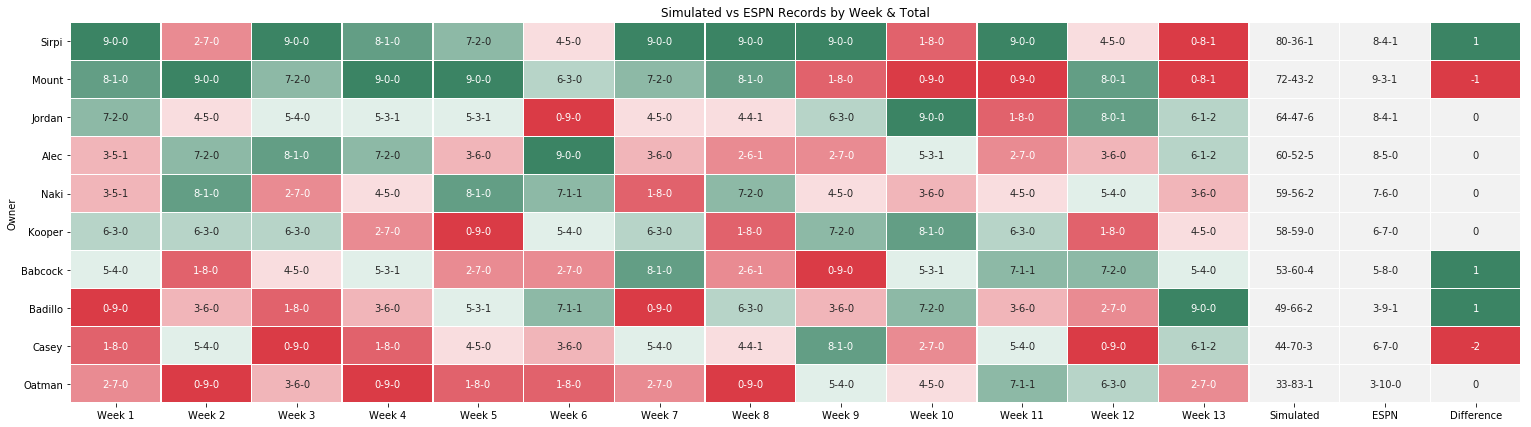

In [30]:
plt.figure(figsize = (num_weeks * 2, 7))
sns.heatmap(analysis_hm, cmap = cmap, annot = analysis_hm_labels,
            cbar = False, fmt = "", linewidth = 0.5)
plt.title("Simulated vs ESPN Records by Week & Total")

Here, we see the teams organized by final rank - by Simulated Record. Each week is coded from worst (0-9) to best (9-0). A list of the Simulated Record coupled with the ESPN actual record is given. The final column is Difference, which is why we created the binary <code>diff</code> column for color. If a team placed better in Simulated vs. Expected (Sirpi), he is denoted with green. If at eam placed worse in Simulated vs. Expected (Mount), he is denoted with red.

### Alternative Win/Loss Methods
Again, luck vs. skill is a big argument within our league, all of whom are self-proclaimed football and FF savants. So, to test this, we try counting wins a different way. In addition to the actual ESPN W/L record, we'll count wins against the average league score. So, if I were to win my head-on matchup in a week and I scored higher than the weekly average, I would go 2-0 for the week. Teams can also go 1-1 and 0-2 depending on weekly performance. In this section, we will explore if that changes who gets into the playoffs (first 4 seeds).

We have the <code>averages</code> and <code>win_loss</code> Data Frames all ready for us to use already, so we can move forward with those with our subsequent data wrangling. A similar Data Frame to create the Simulation Data Frame will be created, in which a column indicating a win or loss for against the league week average will be added:

In [31]:
#initiate empty list
against_averages = []

#loop through the teams, and calculate wins against weekly average
for i in range(len(team_ids)):
    num = team_ids[i]
    raw = (margins_long[margins_long.Team == num].sort_values(by = ["Week"])
                                    .merge(averages,
                                           how = "right",
                                           left_on = "Week",
                                           right_on = "Week"))
    raw = raw.assign(add_win = np.where(raw.Score_x > raw.Score_y, 1, 0),
                     add_loss = np.where(raw.Score_x < raw.Score_y, 1, 0),
                     add_tie = np.where(raw.Score_x == raw.Score_y, 1, 0))
    against_averages.append(raw)
    
ag_av = (pd.concat(against_averages).groupby("Team")
                                    .sum()
                                    .drop(["Week", "Margin",
                                           "Score_x", "Score_y"], axis = 1))

ag_av

,add_win,add_loss,add_tie
Team,,,
1,9,4,0
2,6,7,0
3,8,5,0
4,2,11,0
5,5,8,0
9,7,6,0
11,4,9,0
12,5,8,0
13,7,6,0


This Data Frame output contains the Team ID coupled with how each team would perform against the league weekly average. These values will have to be added to the actual ESPN record:

In [32]:
alt_record = win_loss.merge(ag_av.assign(TeamNum = ag_av.index),
                            how = "left",
                            left_on = "Team",
                            right_on = "TeamNum")
alt_record = alt_record.assign(alt_wins = alt_record.Wins + alt_record.add_win,
                               alt_loss = alt_record.Losses + alt_record.add_loss,
                               alt_ties = alt_record.Ties + alt_record.add_tie)
alt_record["Alt_Record"] = (alt_record.alt_wins.map(str)
                                        + "-"
                                        + alt_record.alt_loss.map(str)
                                        + "-"
                                        + alt_record.alt_ties.map(str))
final_alt = (alt_record.sort_values(by = ["alt_wins", "alt_ties", "Points"],
                                    ascending = False)
                       .assign(new_Standing = np.arange(1, len(team_ids) + 1, 1)))
#final variable selection
alt_analysis = final_alt[["Standing", "new_Standing", "teamname", "Points",
                          "Record", "Alt_Record"]]

alt_analysis

,Standing,new_Standing,teamname,Points,Record,Alt_Record
0,1,1,Mount,1268.0,9-3-1,18-7-1
1,2,2,Sirpi,1411.0,8-4-1,16-9-1
2,3,3,Jordan,1226.0,8-4-1,15-10-1
4,5,4,Naki,1209.0,7-6-0,14-12-0
3,4,5,Alec,1198.0,8-5-0,14-12-0
5,6,6,Kooper,1121.0,6-7-0,13-13-0
7,8,7,Babcock,1124.0,5-8-0,10-16-0
6,7,8,Casey,1055.0,6-7-0,10-16-0
8,9,9,Badillo,1104.0,3-9-1,8-17-1
9,10,10,Oatman,992.0,3-10-0,5-21-0


With the alternative records in place, we do see a significant change. The 4th and 5th seeds, Naki and Alec flip. Naki, with more points scored, plays in the playoffs, and Alec, who was ever so slightly luckier in the regular season, is left out. Obviously, the league would have to discuss quite a bit to implement quite a change, especially when a playoff member is involved with some major changes. Regardless, it's a fun experiment.

### Line Plots
One interesting piece of data ESPN collects and gives is final projected rankings. With limited time, I have yet to explore how much of it is collected in the initial <code>d</code> JSON object, so I instead manually tracked it daily. I'm not sure what ESPN's algorithm is, or if they have one at all, but it changes daily to where ESPN believes the teams will place at the end of the regular season. Let's visualize them:

In [33]:
#import the raw data
source = pd.read_excel("C:/Users/NTellaku/Documents/R/ff/Final Projected Rankings.xlsx",
              sheet_name = "10 Guys One Cup")
source.iloc[:, 0:10] #for output viewing simplicity

,Team,2019-09-04 00:00:00,2019-09-10 00:00:00,2019-09-11 00:00:00,2019-09-12 00:00:00,2019-09-13 00:00:00,2019-09-14 00:00:00,2019-09-16 00:00:00,2019-09-17 00:00:00,2019-09-18 00:00:00
0,Alec,1,6,6,6,6,8,8,7,6
1,Jordan,2,4,1,3,3,1,1,1,1
2,Mount,3,7,7,8,8,7,7,8,8
3,Babcock,4,3,4,1,2,4,5,5,7
4,Kooper,5,8,8,5,5,6,6,4,3
5,Sirpi,6,5,5,7,7,5,4,6,5
6,Casey,7,9,9,9,9,9,9,9,9
7,Badillo,8,2,2,2,1,3,3,3,4
8,Oatman,9,10,10,10,10,10,10,10,10
9,Naki,10,1,3,4,4,2,2,2,2


The dates are a little messy - since they are imported from Excel, they have the time in addition to the date. We should clean those up for the sake of the graphic:

In [34]:
#remove team name and transpose, then apply the team names as column names
source_noteam = source.iloc[:, 1:]
team_names = source.Team
source_t = pd.DataFrame(source_noteam.T)
source_t.columns = team_names


column_dates = list(source.columns.values)[1:]
#putting dates in mm-dd-yy format
dates_fixed = [d.strftime("%m-%d-%y") for d in column_dates]

Text(0.5, 0.98, 'ESPN Final Projected Ranking by Day')

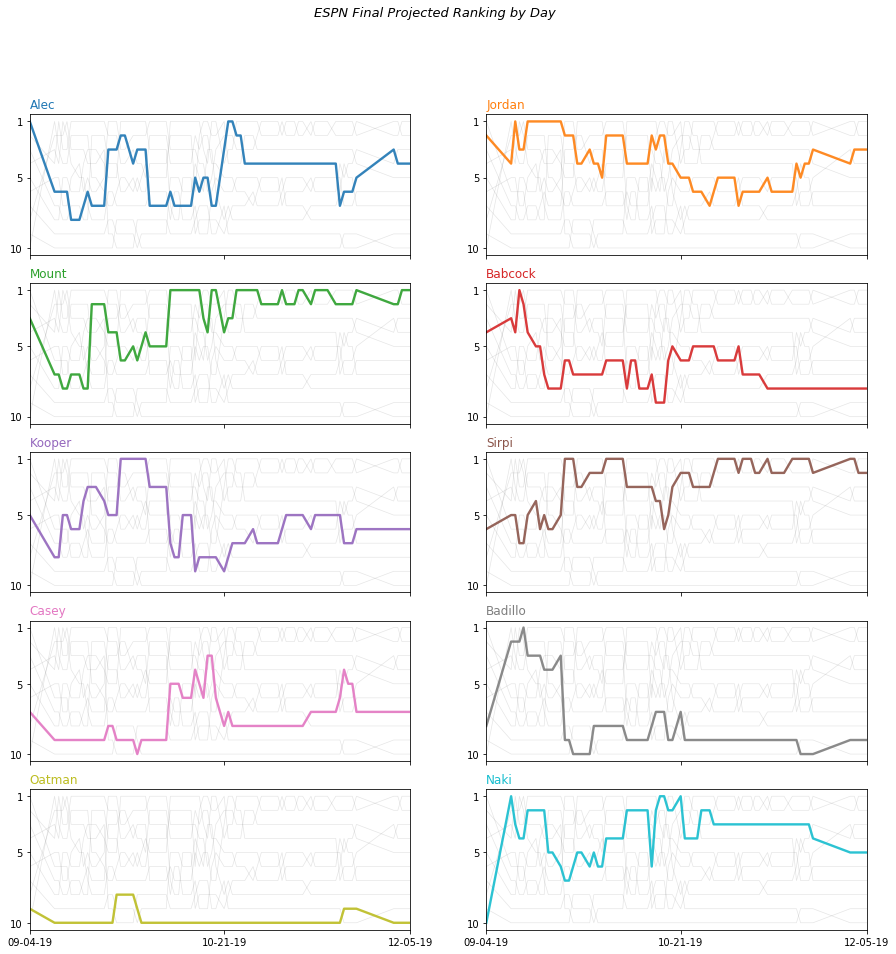

In [35]:
#Now the graphic
#Initialize the figure
plt.style.use("seaborn-dark-palette")

#Create a color palette
palette = plt.get_cmap("tab10")
plt.figure(figsize = (15, 15))

#Multiple Line Plot
num = 0 #iterator
for column in source_t:
    num += 1
    
    #Correct spot in the plot
    plt.subplot(len(team_ids) / 2, 2, num)
    
    #plot every group, but discrete
    for v in source_t:
        plt.plot(column_dates,
                 source_t[v],
                 marker = "",
                 linewidth = 0.7,
                 alpha = 0.2,
                 color = "grey")
        
       
    #Plot the actual lineplot
    color = palette(num - 1)
    
    plt.plot(column_dates,
             source_t[column],
             marker = "",
             color = color,#palette(num - 1),
             linewidth = 2.4,
             alpha = 0.9,
             label = column)
        
    #Same limits for everybody
    plt.ylim(0.5, len(team_ids) + 0.5)
    plt.xlim(column_dates[0], column_dates[-1])
    
    #Specifying ticks and tick locations
    if num in range(len(team_names) + 1) :
        t = [dates_fixed[0],
             dates_fixed[round(len(dates_fixed) / 2)],
             dates_fixed[-1]]
        plt.xticks(t, t)
    if num in range(len(team_names) - 1):
        plt.tick_params(labelbottom = "off")
        
    s = [1, 5, 10]
    plt.yticks(s, s)
        
    #Add a title
    plt.title(column, loc = "left", fontsize = 12,
              fontweight = 0, color = color)#palette(num - 1))
    plt.gca().invert_yaxis()


#General title
plt.suptitle("ESPN Final Projected Ranking by Day",
             fontsize = 13,
             fontweight = 0,
             color = "black",
             style = "italic")